# pyABF-APisolation - Code Walkthrough

pyABF-APisolation, is a simplistic module built to quickly extract action potentials and their raw features from abf files.   This module is built on top of swhardens excellent 'pyABF'. Features are defined by their values located in the Allen Institute's electrophysiology white papers

The goal of this document is to show the exactly how the code goes about extracting the features.

### Step 0: import the dependencies, import the ABF

To begin with we need to import the dependencies. This code utilises numpy, and pandas for data storage and output. Additionally, we utilise the previously written abfderivative tools found here: https://github.com/smestern/abfderivative.

In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from abfderivative import *
from nuactionpotential import *
import pyabf
from pyabf.tools import *
from pyabf import filter
import os
import pandas as pd
import statistics

C:\Users\SMest\Anaconda3\lib\site-packages\pyabf\tools\__init__.py:8: UserWarning: All pyabf.tools modules are experimental (APIs may change)
  warnings.warn("All pyabf.tools modules are experimental (APIs may change)")


Now we simply import our ABF file

In [2]:
abf = pyabf.ABF('./processed/1971003-p.abf')

After importing the ABF file, we can take a look to ensure its working.

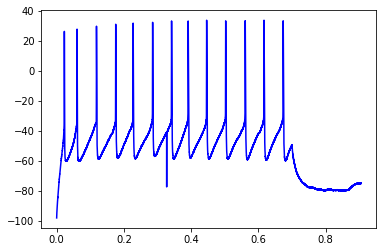

In [3]:
abf.setSweep(4) #Set to sweep number 4
plt.plot(abf.sweepX, abf.sweepY, 'b-') #plot our sweep

Now, we can simply call apisolate. This is the function you will want to use most often. Ap isolate returns both a feature array and the raw traces for all the action potentials found in a file. 

0
%5 threhold avg: 14373.779296876584
Ap count: 1
1
%5 threhold avg: 13122.558593751448
Ap count: 4
2
%5 threhold avg: 11298.285590278416
Ap count: 13
3
%5 threhold avg: 11102.294921872028
Ap count: 23
4
%5 threhold avg: 10453.444260817821
Ap count: 36
5
%5 threhold avg: 10149.002075196082
Ap count: 52
6
%5 threhold avg: 9719.04553865222
Ap count: 71
7
%5 threhold avg: 9431.384858631
Ap count: 92
8
%5 threhold avg: 10242.919921873214
Ap count: 117
9
%5 threhold avg: 8829.345703125266
Ap count: 142
feattag.csv saved


,Sweep,Start Time,End Time,ISI,5% Threshold,mV at Threshold,AP Peak (mV),Ap peak (S),AP fast trough (mV),AP fast trough time (S),AP slow trough (mV),AP slow trough time (S),AP slow trough time ratio,AP height,AP Full width (S),AP Upstroke (mV/mS),AP Upstroke time (S),AP downstroke (mV/mS),AP Downstroke time (S),Upstroke / Downstroke Ratio
0,0.0,0.09860,0.01050,0.80665,14373.779297,-37.170410,28.991699,0.00050,-65.734863,0.00545,-68.328857,0.01030,0.980,94.726562,0.00095,287475.585938,0.00025,-100708.007813,0.00100,-2.854545
1,1.0,0.04685,0.01055,0.10670,13122.558594,-45.043945,27.008057,0.00055,-63.720703,0.00550,-65.307617,0.01045,0.990,90.728760,0.00080,285034.179688,0.00030,-114135.742187,0.00095,-2.497326
2,1.0,0.15355,0.01060,0.20930,13122.558594,-35.156250,30.242920,0.00060,-62.591553,0.00555,-64.636230,0.01010,0.950,92.834473,0.00105,253906.250000,0.00030,-82397.460938,0.00110,-3.081481
3,1.0,0.36285,0.01065,0.54240,13122.558594,-34.332275,33.782959,0.00065,-59.509277,0.00545,-61.767578,0.00985,0.920,93.292236,0.00130,248413.085938,0.00030,-70190.429688,0.00150,-3.539130
4,2.0,0.03480,0.01055,0.05955,11298.285590,-37.200928,27.221680,0.00055,-62.774658,0.00545,-63.568115,0.00810,0.755,89.996338,0.00085,278320.312500,0.00030,-108642.578125,0.00095,-2.561798


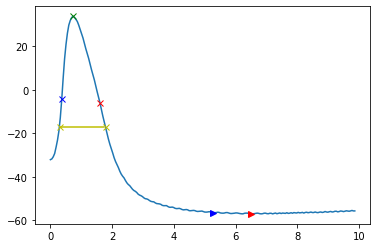

In [4]:
aparray, featarray, abf = apisolate(abf, 0, 'tag', False, True, plot=1)
display(featarray.head())

As you can see, apisolate() returns a reasonably complete feature array. Now lets look at how it determines these values.

### Step 1: Isolate the raw traces

First, apisolate() calls appreprocess(). This function serves to isolate the 'raw' traces, as well as some feature data.  
appreprocess begins by constructing arrays to fill. Then it calls thresholdavg() to find the 5% threshold avg.

In [5]:
thresholdsl = (thresholdavg(abf, 4) * 0.05)
print(thresholdsl)

10453.444260817821


This function utilizes SWhardens pyabf.tools.ap.ap_points_currentSweep() function. The gist of this function is to look for points where the derivative of the sweep crosses 15 mV/mS.
It somewhat acomplishes this by fitting a line and looking for crossings. Then centres on the dV/dT peak.

Text(0, 0.5, 'dV/dT')

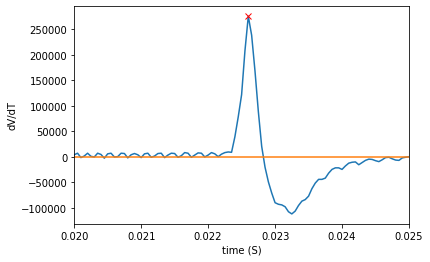

In [6]:
slopex, slopey = derivative(abf,4)
index = pyabf.tools.ap.ap_points_currentSweep(abf)
plt.plot(abf.sweepX[0:700], slopey[0:700])
plt.plot(abf.sweepX[0:700], np.full(700, 20))
plt.plot(abf.sweepX[index], slopey[index], 'rx')
plt.xlim(0.020, 0.025)
plt.xlabel('time (S)')
plt.ylabel('dV/dT')

thresholdavg() simply tabulates the mean of these returned indicies. 

From here, appreprocess() takes each index and steps backwards until it reaches below 5% of the threshold. This is marked as our (single) action potential threshold, and the start of our ap.

In [7]:
 # Now find the point where DVDT falls below the 5% threshold
apstrt = (int(index[0] - (abf.dataPointsPerMs * 2)))
thresholdslloc = index[0]
indexloc = np.nonzero(np.where(slopey[apstrt:thresholdslloc] < thresholdsl, 1, 0))[0]
if indexloc.size < 1:
    idx = apstrt
else:
    indexloc += apstrt
    idx = indexloc[-1]
apstrt = idx

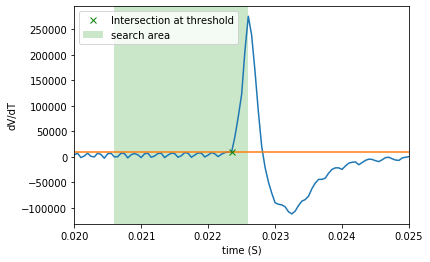

In [8]:
plt.plot(abf.sweepX[0:700], slopey[0:700])
plt.plot(abf.sweepX[0:700], np.full(700, thresholdsl))
plt.axvspan(abf.sweepX[int(index[0] - (abf.dataPointsPerMs * 2))], abf.sweepX[thresholdslloc], facecolor='#2ca02c', alpha=0.25, label='search area')
plt.plot(abf.sweepX[apstrt], slopey[apstrt], 'gx', label='Intersection at threshold')
plt.xlim(0.020, 0.025)
plt.xlabel('time (S)')
plt.ylabel('dV/dT')
plt.legend()

Next, the algorithm searches forwards for the absolute peak of the Action potential

In [9]:
apstrt = (int(index[0] - (abf.dataPointsPerMs * 2)))
if apstrt < 0: 
    apstrt=0
apend = int(index[0]  + (abf.dataPointsPerMs * 3)) 
aploc = np.argmax(abf.sweepY[apstrt:apend]) + apstrt

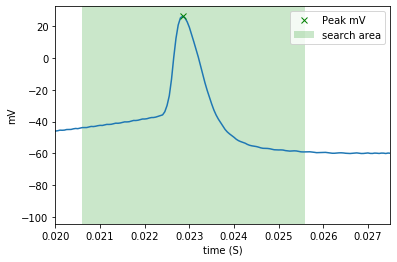

In [10]:
plt.plot(abf.sweepX[0:700], abf.sweepY[0:700])
plt.axvspan(abf.sweepX[apstrt], abf.sweepX[apend], facecolor='#2ca02c', alpha=0.25, label='search area')
plt.plot(abf.sweepX[aploc], abf.sweepY[aploc], 'gx', label='Peak mV')
plt.xlim(0.020, 0.0275)
plt.xlabel('time (S)')
plt.ylabel('mV')
plt.legend()

Now that we have an mostly established peak, we need to cap off the action potential. We cap at either 10ms post peak or the next ap, whatever is sooner.

In [15]:
 ## Now we check to ensure the action potentials do not over lap
if((index[0] - index[1]) > (abf.dataPointsPerMs * 10)): ##if the next ap is over 10ms away then we simple cap off at 10ms
    apend = abs(int(aploc + abf.dataPointsPerMs * 10))
elif apend > index[1]:
    apend = index[1] #otherwise we cap the end at the next threshold
    aploc = np.argmax(abf.sweepY[apstrt:apend]) + apstrt #and re-find the peak
else:
        apend = abs(int(aploc + abf.dataPointsPerMs * 10)) #if this is the last ap in the sweep we cap at 10ms
k,  = abf.sweepY.shape
print(index)
if apend > k:
        apend = int(k) - 1

[452, 1207, 2363, 3506, 4541, 5701, 6828, 7815, 8914, 10047, 11209, 12327, 13466]


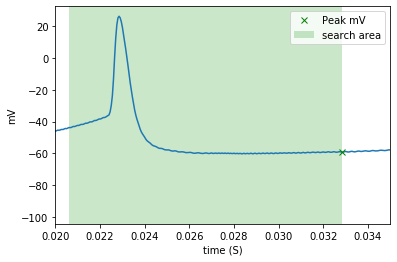

In [14]:
plt.plot(abf.sweepX[0:apend+200], abf.sweepY[0:apend+200])
plt.axvspan(abf.sweepX[apstrt], abf.sweepX[(abf.dataPointsPerMs * 10)+aploc], facecolor='#2ca02c', alpha=0.25, label='search area')
plt.plot(abf.sweepX[apend], abf.sweepY[apend], 'gx', label='Peak mV')
plt.xlim(0.020, 0.035)
plt.xlabel('time (S)')
plt.ylabel('mV')
plt.legend()